# Download requirements

In [ ]:
install.packages('fpp2')

In [1]:
library(fpp2)

Warning message:
"package 'fpp2' was built under R version 3.6.3"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
-- Attaching packages ---------------------------------------------- fpp2 2.4 --
v ggplot2   3.1.1     v fma       2.4  
v forecast  8.14      v expsmooth 2.3  
Warning message:
"package 'forecast' was built under R version 3.6.3"Warning message:
"package 'fma' was built under R version 3.6.3"Warning message:
"package 'expsmooth' was built under R version 3.6.3"


# Load dataset

In [2]:
data <- read.csv('Data.csv')

In [3]:
summary(data)

      Date            Mkt.RF              SMB                HML         
 Min.   :196307   Min.   :-23.2400   Min.   :-15.3900   Min.   :-13.920  
 1st Qu.:197803   1st Qu.: -1.9600   1st Qu.: -1.5400   1st Qu.: -1.395  
 Median :199212   Median :  0.9250   Median :  0.1050   Median :  0.230  
 Mean   :199248   Mean   :  0.5648   Mean   :  0.2214   Mean   :  0.300  
 3rd Qu.:200708   3rd Qu.:  3.4000   3rd Qu.:  2.0650   3rd Qu.:  1.700  
 Max.   :202204   Max.   : 16.1000   Max.   : 18.3800   Max.   : 12.740  
      RMW                CMA                RF             NoDur        
 Min.   :-18.7600   Min.   :-6.7800   Min.   :0.0000   Min.   :-21.020  
 1st Qu.: -0.8175   1st Qu.:-1.0000   1st Qu.:0.1400   1st Qu.: -1.242  
 Median :  0.2400   Median : 0.1100   Median :0.3800   Median :  1.080  
 Mean   :  0.2752   Mean   : 0.2947   Mean   :0.3641   Mean   :  1.049  
 3rd Qu.:  1.2775   3rd Qu.: 1.4900   3rd Qu.:0.5100   3rd Qu.:  3.720  
 Max.   : 13.3800   Max.   : 9.0600   Max.  

# Predict cho Telcm portfolio

#### Lấy dữ liệu của Telcm porfolio

In [4]:
series <- ts(data = data$Telcm, start = c(1963,7), end = c(2022,4), frequency = 12)

In [5]:
series %>% summary()

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-16.2200  -1.8600   1.0150   0.8295   3.5775  21.3400 

#### Khảo sát tập train từ 7/1963 - 12/1989

In [6]:
log_scale <- function(x) {log(1+x/100)} #scaler
log_inv <- function(x) {(exp(x)-1)*100} #inverter

In [7]:
series_train <- series %>% window(end=c(1989,12)) %>% log_scale

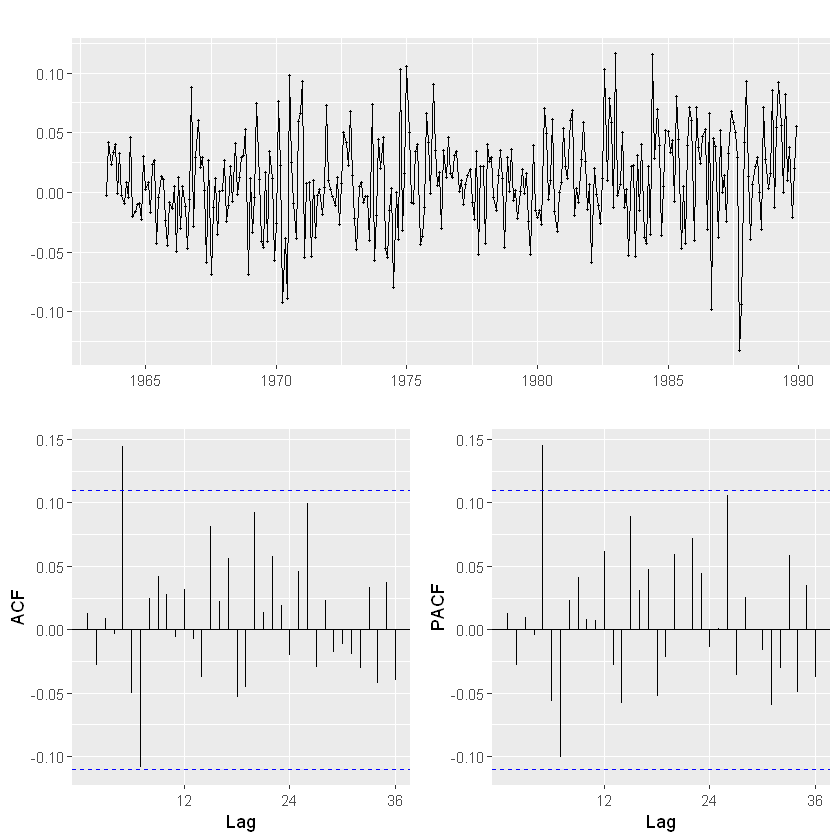

In [8]:
series_train %>% ggtsdisplay()

Biểu đồ dao động không có trend và seasonality quan sát được, nên không cần lấy difference và seasonal difference. <br>
Thử lại với hàm dò tìm bậc d: ndiffs cho order và nsdiffs cho seasonal.

In [9]:
series_train %>% ndiffs()

[1] 1

In [10]:
series_train %>% nsdiffs()

[1] 0

Kết quả d = 0 cho cả order và seasonal.

#### Phân tích p và q cho mô hình ARIMA

Thử dò tìm (p,d,q) với chế độ auto theo thuật toán Hyndman-Khandakar.

In [11]:
fit <- auto.arima(series_train, stepwise = FALSE, approximation = FALSE)
fit

Series: series_train 
ARIMA(0,1,1) 

Coefficients:
          ma1
      -0.9821
s.e.   0.0092

sigma^2 estimated as 0.001592:  log likelihood=570.19
AIC=-1136.38   AICc=-1136.34   BIC=-1128.86


	Ljung-Box test

data:  Residuals from ARIMA(0,1,1)
Q* = 24.4, df = 23, p-value = 0.382

Model df: 1.   Total lags used: 24



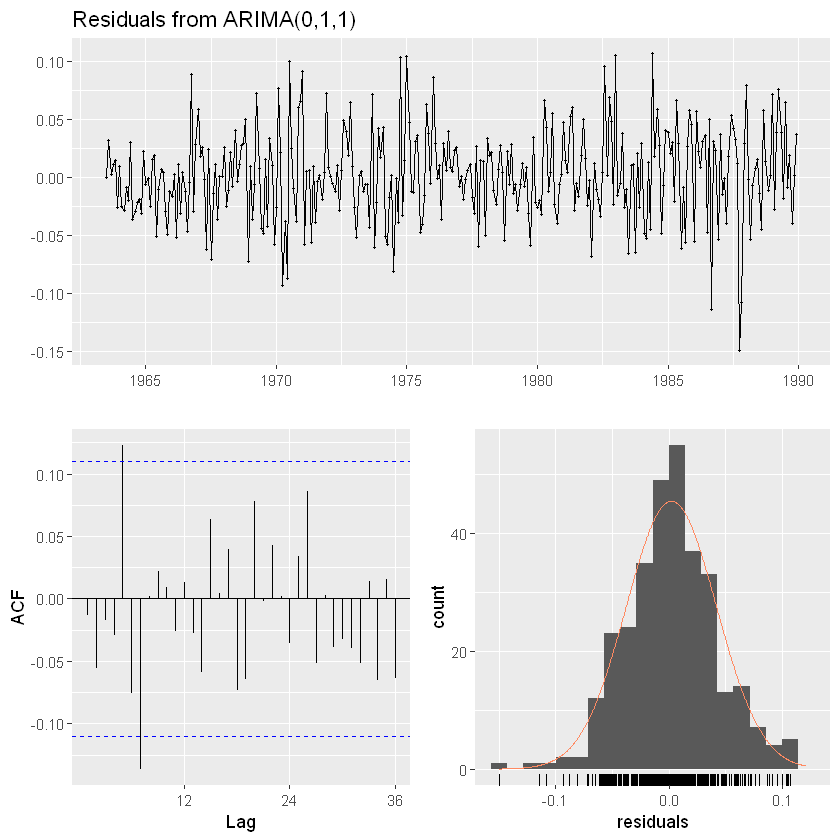

In [12]:
fit %>% checkresiduals()

Auto đề xuất ARIMA(0,1,1), Ljung-Box test cho p-value > 0.05 nên mô hình phù hợp.

Thử tất cả các mô hình đề xuất và so sánh theo tiêu chuẩn thông tin AIC, AICc, BIC, RMSE.

In [13]:
model <- list(ARIMA000 = c(0,0,0), ARIMA001 = c(0,0,1), ARIMA002 = c(0,0,2), ARIMA100 = c(1,0,0), ARIMA101 = c(1,0,1), 
              ARIMA102 = c(1,0,2), ARIMA200 = c(2,0,0), ARIMA201 = c(2,0,1), ARIMA202 = c(2,0,2),
              ARIMA010 = c(0,1,0), ARIMA011 = c(0,1,1), ARIMA012 = c(0,1,2), ARIMA110 = c(1,1,0), ARIMA111 = c(1,1,1), 
              ARIMA112 = c(1,1,2), ARIMA210 = c(2,1,0), ARIMA211 = c(2,1,1), ARIMA212 = c(2,1,2))

In [14]:
result <- NULL
for (m in model)
{
    fit <- Arima(series_train, order = m)
    fitted <- ts(data = fit$fitted, start = c(1963,7), end = c(1989,12), frequency = 12) %>% log_inv
    rmse <- sqrt(mean((log_inv(series_train) - fitted)^2))
    result <- rbind(result, c(AIC = fit$aic, AICc = fit$aicc, BIC = fit$bic, RMSE = rmse))
}
row.names(result) <- names(model)
result

,AIC,AICc,BIC,RMSE
ARIMA000,-1141.8801,-1141.8420,-1134.3560,4.035154
ARIMA001,-1139.9382,-1139.8617,-1128.6520,4.034833
ARIMA002,-1138.1977,-1138.0699,-1123.1495,4.033120
ARIMA100,-1139.9349,-1139.8585,-1128.6488,4.034851
ARIMA101,-1142.6203,-1142.4925,-1127.5721,3.992591
ARIMA102,-1137.1869,-1136.9946,-1118.3767,4.026578
ARIMA200,-1138.1870,-1138.0592,-1123.1388,4.033187
ARIMA201,-1135.9350,-1135.7427,-1117.1247,4.034850
ARIMA202,-1140.7368,-1140.4667,-1118.1645,3.979298
ARIMA010,-924.4541,-924.4414,-920.6952,5.662647


Mô hình ARIMA(2,0,2) cho kết quả RMSE thấp nhất trên tập train.

#### Đánh giá mô hình ARIMA(2,0,2) trên tập test

In [7]:
pred <- NULL
for (i in 0:387)
{
    train <- series %>% subset(end = length(series)-388+i) %>% log_scale
    fit <- Arima(train, order = c(2,0,2))
    pred <- c(pred, forecast(fit, h = 1)$mean %>% log_inv) 
}
pred <- ts(data = pred, start = c(1990,1), frequency = 12)
true <- series %>% window(start = c(1990,1))
rmse <- sqrt(mean((true-pred)^2))
rmse

[1] 5.052111

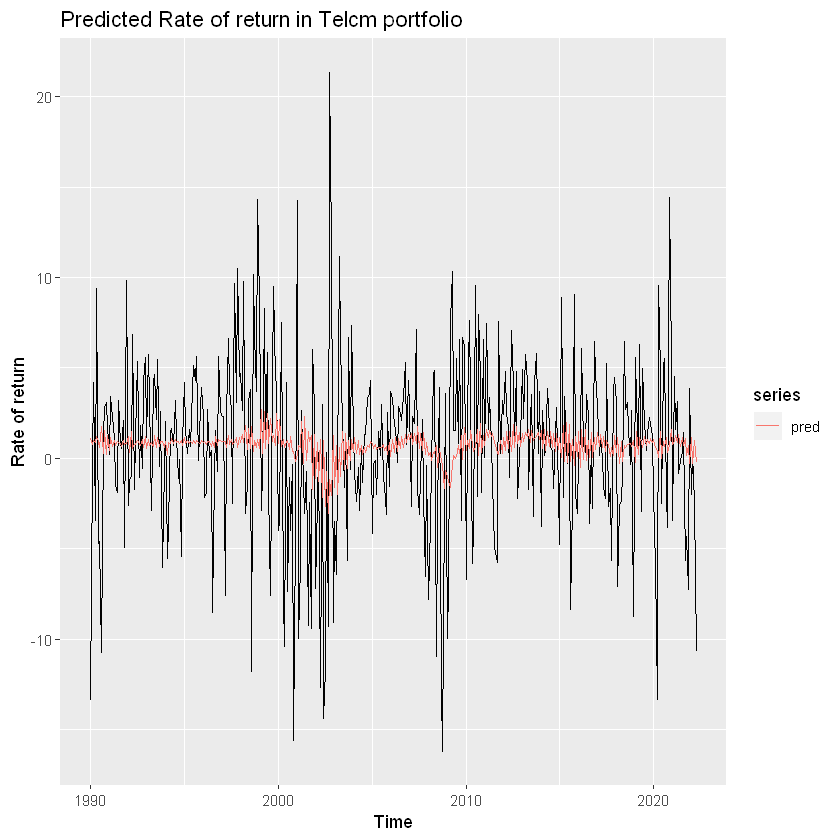

In [8]:
autoplot(true) + autolayer(pred) + labs(y = "Rate of return", title = "Predicted Rate of return in Telcm portfolio")

In [9]:
as.numeric(pred)

[1]  1.086738504  0.753117912  0.990164052  0.880293215  1.205527413
  [6]  0.917943129  0.579418176  1.766313948  0.254399199  1.538005220
 [11]  0.197399656  1.280901068  0.427084238  1.148248747  0.658563201
 [16]  0.961138671  0.723822153  0.943159791  0.871704574  0.792448504
 [21]  0.678105053  0.989916585  0.787899232  0.813274854  1.200997708
 [26]  0.345892048  1.497117235  0.549682563  0.786531814  0.772652402
 [31]  0.975952196  0.842474381  0.691671583  1.017507933  0.612577738
 [36]  1.222844504  0.539153871  1.030795717  0.706824902  0.894496660
 [41]  0.630870370  1.245597225  0.585380480  1.156382545  0.629963990
 [46]  0.932302689  0.903488207  0.597838266  0.903462037  0.229936420
 [51]  0.856808601  0.798451779  1.092608986  0.797203799  1.030284875
 [56]  0.890740796  0.928528038  0.794799416  0.979847320  0.701738867
 [61]  1.152423695  0.813070175  0.989145095  0.805646115  0.943106170
 [66]  0.811541944  0.961039791  0.803391311  0.973468422  0.876988038
 [71]  0.801589290  0.976933067  0.883657097  0.942766993  0.762175691
 [76]  0.950953268  0.934821012  0.674844998  0.947106441  0.587372979
 [81]  1.208755711  0.718474876  1.057752132  0.956102308  0.914961435
 [86]  0.926825663  0.905323319  0.595132576  1.284400951  0.759810567
 [91]  1.063368470  0.744605367  0.851465596  1.166409586  0.609975806
 [96]  1.168545303  0.870563239  1.289334591  0.861460600  1.797994051
[101]  0.476081576  1.665159471  0.522140300  1.763497207  0.369263461
[106]  0.975460456  0.572248240  1.050975235  0.547795780  2.685584558
[111]  0.242754607  2.610365912  0.559586933  2.459116543  0.815298816
[116]  2.195693756  0.904536899  1.265686469  0.703093713  2.502521643
[121]  0.799250564  2.126474493  0.627832766  1.019815974  0.575159676
[126]  0.925612323  1.006721140  0.472531102  1.195385039  0.378914273
[131]  0.390502725 -0.184744276  0.227395789  0.682459314  0.591483998
[136]  2.038450850 -0.309342629  2.301407889 -0.142094538  1.494240871
[141]  0.920319836  1.274560175 -1.726224450  1.325481808 -1.093238707
[146]  0.899339932 -1.275574904  1.017198286 -2.149786132  0.962340849
[151] -2.689261513 -0.729513332 -3.078492412 -1.157747419 -2.066151285
[156]  1.287330038 -1.597631421  0.712937275 -1.997498133  0.596702112
[161] -0.987876244  1.470600253 -0.598130451  1.375489507 -0.541753117
[166]  0.973688352 -0.120381816  1.053904711  0.352982242  1.175299346
[171]  0.272817466  0.961389064  0.182986549  0.716875036  0.218779071
[176]  0.614044117  0.332282736  0.710657643  0.570253950  0.939371498
[181]  0.832876496  0.521908008  0.773766166  0.484115704  0.596988953
[186]  0.589357517  0.582350426  0.787767050  0.449036174  0.649395741
[191]  0.204362536  0.857844616  0.090551476  1.064682701  0.310178520
[196]  1.161410786  0.388076128  1.091716191  0.524878626  1.196145107
[201]  0.612719585  1.335905099  0.892428758  1.300655178  1.066046195
[206]  1.388206399  0.754109595  1.392661894  0.790451418  1.753945530
[211]  0.568019183  1.384845523  0.414806611  1.435612318  0.205147648
[216]  0.892553918  0.150747034  0.308744615 -0.131488682  0.325617461
[221]  0.277388703  0.732860458 -0.510163843  0.520830988 -0.141672957
[226] -0.418869033 -1.664827969 -0.694505541 -0.992858062 -1.297669435
[231] -1.635089276 -0.335043443  0.164163561  0.002322698  0.089497363
[236]  0.696359353  0.238864008  1.258913620 -0.069552603  1.719633934
[241]  0.457780420  0.990596966  0.548131626  1.559188951  0.761931755
[246]  0.357971155  0.640374089  1.585204177  0.172211655  1.933185146
[251]  0.292859270  1.281753370  0.687534442  1.591185014  1.145571757
[256]  1.526727503  1.223409237  1.387425661  0.893619032  0.774663903
[261]  0.316379366  0.191285135  0.969123027  0.260996374  1.174535048
[266]  0.417683364  1.470008638  0.538700034  1.479478004  0.348753955
[271]  1.864377953  0.592161131  1.785630571  0.802665586  1.436936352
[276]  0.630600648  1.372973885  0.904327256  1.421470510  1.218065528
[281]  1.601199662  0.8663